# WaveNet - Fit a Sample

In [1]:
import sys
#sys.path.append('../../src/')
sys.path.append('../../network/')

In [2]:
import os
import torch
from types import SimpleNamespace
torch.cuda.empty_cache()

In [3]:
from models.wavenet_no_padding_good_3.model import WaveNet
from models.wavenet_no_padding_good_3.utils.data import DataLoader

In [4]:
params = SimpleNamespace(
    layer_size=10,
    stack_size=5,
    in_channels=256,
    res_channels=512,
    lr=2e-3,
    sample_size=15_000,
    sample_rate=22_050,
    epochs=10_000,
    model_dir='../../network/weights/wavenet/'
)

In [5]:
class Trainer:
    def __init__(self,
                 layer_size: int = 10,
                 stack_size: int = 5,
                 in_channels: int = 256,
                 res_channels: int = 512,
                 lr: float = 2e-3,
                 sample_size: int = 100_000,
                 sample_rate: int =22_050,
                 epochs: int = 10_000,
                 data_dir: str = '.',
                 model_dir: str = './',
                 model_name: str = None):
        """
        """
        self.epochs = epochs
        self.model_dir = model_dir
        self.model_name = model_name
        
        self.wavenet = WaveNet(layer_size, stack_size, in_channels, res_channels, lr=lr)
        self.data_loader = DataLoader(data_dir, self.wavenet.receptive_fields,
                                      sample_size, sample_rate, in_channels)

    def infinite_batch(self):
        while True:
            for dataset in self.data_loader:
                for inputs, targets in dataset:
                    yield inputs, targets

    def run(self):
        total_steps = 0

        for inputs, targets in self.infinite_batch():
            loss = self.wavenet.train(inputs, targets)

            total_steps += 1

            print('[{0}/{1}] loss: {2}'.format(total_steps, self.epochs, loss))

            if total_steps > self.epochs:
                break

            if total_steps % 200 == 0:
                self.wavenet.save(self.model_dir, self.model_name)

In [6]:
#params.data_dir = '../../data/processed/tapping/tapping-glass/partial/'
#params.model_name = 'wavenet-tapping-glass-tiny-jar-2'
params.data_dir = '../../data/processed/brushing/brushing-rode-mic/partial/'
params.model_name = 'wavenet-brushing-rode-mic-nn'

In [ ]:
trainer = Trainer(**params.__dict__)
#trainer.wavenet.load(params.model_dir, params.model_name)
trainer.run()

2 GPUs are detected.
../../data/processed/brushing/brushing-rode-mic/partial/H2Cam080Ye8-silicon-brush-Copy1.wav
<class 'numpy.ndarray'>
15000
[1/10000] loss: 5.5451202392578125
[2/10000] loss: 5.5448808670043945
[3/10000] loss: 5.544785499572754
[4/10000] loss: 5.544907093048096
[5/10000] loss: 5.54452657699585


# GENERATION

In [9]:
from models.wavenet_no_padding_good.model import WaveNet
import models.wavenet_no_padding_good_4.utils.data as utils

import torch
import librosa
import librosa.output
import datetime
import numpy as np
import random

In [10]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [22]:
params = SimpleNamespace(
    layer_size=10,
    stack_size=5,
    in_channels=256,
    res_channels=512,
    sample_size=25_000,
    sample_rate=22_050,
    length=10
)

In [23]:
class Generator:
    def __init__(self, args):
        self.args = args

        self.wavenet = WaveNet(args.layer_size, args.stack_size,
                               args.in_channels, args.res_channels)

        self.wavenet.load(args.model_dir, args.model_name, args.step)

    @staticmethod
    def _variable(data):
        tensor = torch.from_numpy(data).float()

        if torch.cuda.is_available():
            return torch.autograd.Variable(tensor.cuda())
        else:
            return torch.autograd.Variable(tensor)

    def _make_seed(self, audio):
        audio = np.pad([audio], [[0, 0], [0, 0], [0, 0]], 'constant')

        if self.args.sample_size:
            seed = audio[:, :self.args.sample_size, :]
        else:
            seed = audio[:, :self.wavenet.receptive_fields*2, :]

        return seed

    def _get_seed_from_audio(self, filepath):
        audio = utils.load_audio(filepath, self.args.sample_rate)
        i = random.choice(np.arange(0, len(audio)-self.wavenet.receptive_fields))
        audio = audio[i:]
        audio_length = len(audio)

        audio = utils.mu_law_encode(audio, self.args.in_channels)
        audio = utils.one_hot_encode(audio, self.args.in_channels)

        seed = self._make_seed(audio)

        return self._variable(seed), audio_length

    def _save_to_audio_file(self, data):
        data = data[0].cpu().data.numpy()
        print(data.shape)
        data = utils.one_hot_decode(data, axis=1)
        audio = utils.mu_law_decode(data, self.args.in_channels)

        librosa.output.write_wav(self.args.out, np.array(audio, dtype="float32"), self.args.sample_rate)
        print('Saved wav file at {}'.format(self.args.out))

        return audio#librosa.get_duration(y=audio, sr=self.args.sample_rate)

    def generate(self):
        
        with torch.no_grad():
            outputs = []
            inputs, audio_length = self._get_seed_from_audio(self.args.seed)

            while True:
                new = self.wavenet.generate(inputs)

                outputs = torch.cat((outputs, new), dim=1) if len(outputs) else new

                print('{0}/{1} samples are generated.'.format(len(outputs[0]), self.args.length*self.args.sample_rate))

                if len(outputs[0]) >= self.args.length*self.args.sample_rate:
                    break

                inputs = torch.cat((inputs[:, :-len(new[0]), :], new), dim=1)

            outputs = outputs[:, :self.args.length*self.args.sample_rate, :]

        return self._save_to_audio_file(outputs)

In [24]:
params.model_dir = '../../network/weights/wavenet/'
params.model_name = 'wavenet-tapping-glass-no-padding-no-determ'
params.step = 0
params.seed = '../../data/processed/tapping/tapping-glass/PLhDdb5CgZ4-hour-glass.wav'
params.out = '../../network/outputs/wavenet/wavenet-out-tapping-glass-hour-glass-nn-2.wav'

In [25]:
generator = Generator(params)
x = generator.generate()

2 GPUs are detected.
Loading model from ../../network/weights/wavenet/
../../data/processed/tapping/tapping-glass/PLhDdb5CgZ4-hour-glass.wav
19885/220500 samples are generated.
39770/220500 samples are generated.
59655/220500 samples are generated.
79540/220500 samples are generated.
99425/220500 samples are generated.
119310/220500 samples are generated.
139195/220500 samples are generated.
159080/220500 samples are generated.
178965/220500 samples are generated.
198850/220500 samples are generated.
218735/220500 samples are generated.
238620/220500 samples are generated.
(220500, 256)
Saved wav file at ../../network/outputs/wavenet/wavenet-out-tapping-glass-hour-glass-nn-2.wav


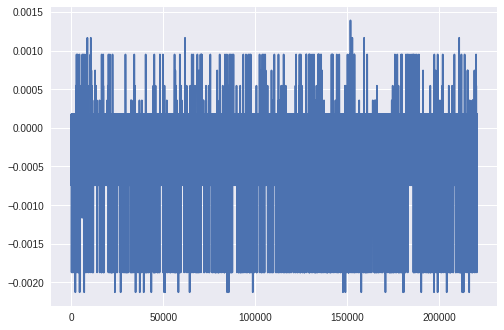

In [26]:
plt.plot(x)
#plt.ylim([-0.002, 0.002])

In [90]:
x_clipped = np.clip(x, -0.0009, 0.0005)
x_clipped = np.array(x- x_clipped, dtype="float32")

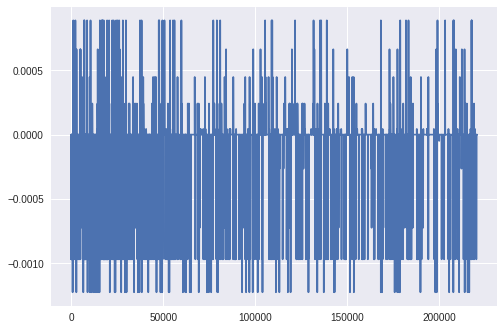

In [91]:
plt.plot(x_clipped)

In [92]:
librosa.output.write_wav('../../network/outputs/wavenet/wavenet-out-tapping-glass-hour-glass-nn-clipped.wav',
                         x_clipped, params.sample_rate)